<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Pytorch/Pytorch_linear_house_price_(boston_and_california).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML regression house price boston

## Prepare data

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
dataset = pd.DataFrame(boston.data)
#Adding the feature names to the dataframe
dataset.columns = boston.feature_names
#Adding target variable to dataframe
dataset['PRICE'] = boston.target 
# Median value of owner-occupied homes in $1000s
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
# Split-out validation dataset

X = dataset.drop('PRICE',axis=1) #
Y = dataset['PRICE'] # last columns

In [ ]:

validation_size = 0.20
seed = 7
X_train, X_temp, y_train, y_temp = train_test_split(X, Y,stratify=X['CHAS'],
                                                                random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,stratify=X_temp['CHAS'],
                                                                random_state=seed)

In [ ]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train=transformer.transform(X_train)
X_val=transformer.transform(X_val)
X_test=transformer.transform(X_test)

## Pytorch Dataset

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(379, 13) (379,)
(95, 13) (95,)
(32, 13) (32,)


In [ ]:
def convert_pytorch_dataset(X_train,y_train,X_val,y_val,X_test,y_test):
  X_train_py=torch.from_numpy(X_train).type(torch.float32)
  y_train_py=torch.from_numpy(y_train.values).type(torch.float32)
  X_val_py=torch.from_numpy(X_val).type(torch.float32)
  y_val_py=torch.from_numpy(y_val.values).type(torch.float32)
  X_test_py=torch.from_numpy(X_test).type(torch.float32)
  y_test_py=torch.from_numpy(y_test.values).type(torch.float32)

  print(X_train_py.shape,y_train_py.shape)
  print(X_val_py.shape,y_val_py.shape)
  print(X_test_py.shape,y_test_py.shape)
  return X_train_py,y_train_py,X_val_py,y_val_py,X_test_py,y_test_py

In [ ]:
X_train_py,y_train_py,X_val_py,y_val_py,X_test_py,y_test_py=\
convert_pytorch_dataset(X_train,y_train,X_val,y_val,X_test,y_test)

torch.Size([379, 13]) torch.Size([379])
torch.Size([95, 13]) torch.Size([95])
torch.Size([32, 13]) torch.Size([32])


In [ ]:
#X_train_py=torch.tensor(X_train)
#y_train_py=torch.tensor(y_train.values)
#X_val_py=torch.tensor(X_val)
#y_val_py=torch.tensor(y_val.values)
#X_test_py=torch.tensor(X_test)
#y_test_py=torch.tensor(y_test.values)

#print(X_train_py.shape,y_train_py.shape)
#print(X_val_py.shape,y_val_py.shape)
#print(X_test_py.shape,y_test_py.shape)

## Pytorch model

In [ ]:
y_train_py=torch.reshape(y_train_py,(y_train_py.shape[0],1))
y_val_py=torch.reshape(y_val_py,(y_val_py.shape[0],1))
y_test_py=torch.reshape(y_test_py,(y_test_py.shape[0],1))

In [ ]:
y_train_py.shape

torch.Size([379, 1])

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, X_val,
                  y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        y_train_pred = model(X_train) # <1>
        loss_train = loss_fn(y_train_pred, y_train)

        y_val_pred = model(X_val) # <1>
        loss_val = loss_fn(y_val_pred, y_val)
        
        optimizer.zero_grad() # reset param du , db to zero to avoid accumlate each step()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [ ]:
seq_model = nn.Sequential(
            nn.Linear(X_train_py.shape[1], 20), # <1>
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=13, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Use optimizer SGD
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>
#optimizer = optim.Adam(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    X_train = X_train_py,
    X_val = X_val_py, 
    y_train = y_train_py,
    y_val = y_val_py)

Epoch 1, Training loss 592.9358, Validation loss 646.5436
Epoch 20, Training loss 509.7381, Validation loss 555.9503
Epoch 40, Training loss 349.8184, Validation loss 389.5589
Epoch 60, Training loss 207.4962, Validation loss 240.0426
Epoch 80, Training loss 134.1762, Validation loss 160.2724
Epoch 100, Training loss 101.5748, Validation loss 123.1256
Epoch 120, Training loss 85.3864, Validation loss 103.9224
Epoch 140, Training loss 73.8299, Validation loss 90.2738
Epoch 160, Training loss 65.2161, Validation loss 80.1177
Epoch 180, Training loss 59.5287, Validation loss 73.6118
Epoch 200, Training loss 55.5170, Validation loss 69.2977
Epoch 220, Training loss 52.7903, Validation loss 66.4584
Epoch 240, Training loss 50.8327, Validation loss 64.4306
Epoch 260, Training loss 49.3263, Validation loss 62.8727
Epoch 280, Training loss 48.1051, Validation loss 61.6098
Epoch 300, Training loss 47.0722, Validation loss 60.5384
Epoch 320, Training loss 46.1680, Validation loss 59.5916
Epoch 3

In [ ]:
y_test_pred=seq_model(X_test_py)
criterion = nn.MSELoss()
mse = criterion(y_test_pred,y_test_py)
rmse = torch.sqrt(criterion(y_test_pred,y_test_py))
print('mse',mse) # best: 10.0 with ML model grid search
print('rmse',rmse)

mse tensor(17.4444, grad_fn=<MseLossBackward>)
rmse tensor(4.1767, grad_fn=<SqrtBackward>)


In [ ]:
# use optimizer Adam
optimizer = optim.Adam(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    X_train = X_train_py,
    X_val = X_val_py, 
    y_train = y_train_py,
    y_val = y_val_py)

Epoch 1, Training loss 28.6858, Validation loss 47.6721
Epoch 20, Training loss 24.7191, Validation loss 36.1491
Epoch 40, Training loss 22.1487, Validation loss 31.7087
Epoch 60, Training loss 20.3845, Validation loss 28.6600
Epoch 80, Training loss 19.1572, Validation loss 26.4279
Epoch 100, Training loss 18.2356, Validation loss 25.0200
Epoch 120, Training loss 17.2523, Validation loss 23.5606
Epoch 140, Training loss 16.5357, Validation loss 23.0103
Epoch 160, Training loss 15.8110, Validation loss 22.1859
Epoch 180, Training loss 15.1613, Validation loss 21.5624
Epoch 200, Training loss 14.5848, Validation loss 20.8612
Epoch 220, Training loss 14.0552, Validation loss 20.2163
Epoch 240, Training loss 13.5668, Validation loss 19.6475
Epoch 260, Training loss 13.1083, Validation loss 19.1262
Epoch 280, Training loss 12.6716, Validation loss 18.6409
Epoch 300, Training loss 12.2526, Validation loss 18.1736
Epoch 320, Training loss 11.8484, Validation loss 17.7484
Epoch 340, Training 

In [ ]:
y_test_pred=seq_model(X_test_py)
criterion = nn.MSELoss()
mse = criterion(y_test_pred,y_test_py)
rmse = torch.sqrt(criterion(y_test_pred,y_test_py))
print('mse',mse) # best: 10.0 with ML model grid search
print('rmse',rmse)

mse tensor(7.8933, grad_fn=<MseLossBackward>)
rmse tensor(2.8095, grad_fn=<SqrtBackward>)


# Implement Linear Regression on Boston Housing Dataset by PyTorch (very good)

https://medium.com/analytics-vidhya/implement-linear-regression-on-boston-housing-dataset-by-pytorch-c5d29546f938

In [ ]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

In [ ]:
bos = load_boston()
bos.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [ ]:
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df['Price'] = bos.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
# Normalize Data
data = df[df.columns[:-1]]
data = data.apply(
    lambda x: (x - x.mean()) / x.std()
)

data['Price'] = df.Price

In [ ]:
X = data.drop('Price', axis=1).to_numpy()
Y = data['Price'].to_numpy()
print(X.shape,Y.shape)

(506, 13) (506,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


In [ ]:
import torch
print(torch.__version__)

1.6.0+cu101


In [ ]:
n_train = X_train.shape[0]
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float).view(-1, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float).view(-1, 1)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

torch.Size([354, 13]) torch.Size([152, 13]) torch.Size([354, 1]) torch.Size([152, 1])


## Pytorch model (very simple and good)

In [ ]:
# Model 1 : no hiden layer
w_num = X_train.shape[1] # input w_num, output : 1
net = torch.nn.Sequential(torch.nn.Linear(w_num, 1))

#torch.nn.init.normal_(net[0].weight, mean=0, std=0.1)
#torch.nn.init.constant_(net[0].bias, val=0)

Only two parameters are accepted by nn.Linear, which are the dimension of weight and the dimension of output respectively.
Parameters don’t need to be initialized in our examination because Linear will do it automatically.

## The usage of DataLoader
DataLoader is implemented in PyTorch, which will return an iterator to iterate training data by batch. It’s easy to use, let’s start from constructing a Dataset of Tensor.

In [ ]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
datasets

Then, generate a DataLoder by using this Dataset.

In [ ]:
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

batch_size is the size of each batch in which data returned. Data will be returned in random sequence if shuffle is True.

In [ ]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    for x, y in train_iter:
        output = net(x)
        l = loss(output, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print("epoch {} loss: {:.4f}".format(epoch + 1, l.item()))

epoch 1 loss: 7.5077
epoch 2 loss: 13.6321
epoch 3 loss: 7.0498
epoch 4 loss: 47.7818
epoch 5 loss: 6.4849


- Train the training set for 5 epochs. The training process is roughly as follows.
- Load a batch of data.
- Predict the batch of the data through net.
- Calculate the loss value by predict value and true value.
- Clear the grad value optimizer stored.
- Backpropagate the loss value.
- Update optimizer.

## Evaluate X and Y test

In [ ]:
print(loss(net(X_test), Y_test).item())

27.881694793701172


In [ ]:
y_test_pred=net(X_test)
criterion = nn.MSELoss()
mse = criterion(y_test_pred,Y_test)
rmse = torch.sqrt(criterion(y_test_pred,Y_test))
print('mse',mse) # best: 10.0 with ML model grid search
print('rmse',rmse)

mse tensor(27.8817, grad_fn=<MseLossBackward>)
rmse tensor(5.2803, grad_fn=<SqrtBackward>)


## Use seq model (complex and performance not good)

In [ ]:
#Model 2: hiden layer
w_num = X_train.shape[1] 
seq_model = nn.Sequential(
            nn.Linear(w_num, 20), # <1>
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 1)) # <2>

In [ ]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    for x, y in train_iter:
        output = net(x)
        l = loss(output, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    #print("epoch {} loss: {:.4f}".format(epoch + 1, l.item()))

In [ ]:
y_test_pred=seq_model(X_test)
criterion = nn.MSELoss()
mse = criterion(y_test_pred,Y_test)
rmse = torch.sqrt(criterion(y_test_pred,Y_test))
print('mse',mse) # best: 10.0 with ML model grid search
print('rmse',rmse)

mse tensor(518.2205, grad_fn=<MseLossBackward>)
rmse tensor(22.7645, grad_fn=<SqrtBackward>)


In [ ]:
#Model 2: hiden layer
w_num = X_train.shape[1] 
seq_model = nn.Sequential(
            nn.Linear(w_num, 20), # <1>
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 1)) # <2>

In [ ]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    for x, y in train_iter:
        output = net(x)
        l = loss(output, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    #print("epoch {} loss: {:.4f}".format(epoch + 1, l.item()))

In [ ]:
y_test_pred=seq_model(X_test)
criterion = nn.MSELoss()
mse = criterion(y_test_pred,Y_test)
rmse = torch.sqrt(criterion(y_test_pred,Y_test))
print('mse',mse) # best: 10.0 with ML model grid search
print('rmse',rmse)

mse tensor(537.8026, grad_fn=<MseLossBackward>)
rmse tensor(23.1906, grad_fn=<SqrtBackward>)


# Revisting Boston Housing with Pytorch

[![AnalyticsDojo](https://github.com/rpi-techfundamentals/fall2018-materials/blob/master/fig/final-logo.png?raw=1)](http://rpi.analyticsdojo.com)
<center><h1>Revisting Boston Housing with Pytorch</h1></center>
<center><h3><a href = 'http://rpi.analyticsdojo.com'>rpi.analyticsdojo.com</a></h3></center>

In [ ]:
#Let's get rid of some imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Overview
- Getting the Data
- Reviewing Data
- Modeling 
- Model Evaluation
- Using Model
- Storing Model


## Getting Data 
- Available in the [sklearn package](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) as a Bunch object (dictionary).
- From FAQ: ["Don’t make a bunch object! They are not part of the scikit-learn API. Bunch objects are just a way to package some numpy arrays. As a scikit-learn user you only ever need numpy arrays to feed your model with data."](http://scikit-learn.org/stable/faq.html)
- Available in the UCI data repository. 
- Better to convert to Pandas dataframe. 

In [ ]:
#From sklearn tutorial.
from sklearn.datasets import load_boston
boston = load_boston()
print( "Type of boston dataset:", type(boston))

Type of boston dataset: <class 'sklearn.utils.Bunch'>


In [ ]:
#A bunch is you remember is a dictionary based dataset.  Dictionaries are addressed by keys. 
#Let's look at the keys. 
print(boston.keys())


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [ ]:
#DESCR sounds like it could be useful. Let's print the description.
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
# Let's change the data to a Panda's Dataframe
import pandas as pd
boston_df = pd.DataFrame(boston['data'] )
boston_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
#Now add the column names.
boston_df.columns = boston['feature_names']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
#Add the target as PRICE. 
boston_df['PRICE']= boston['target']
print(boston_df.shape)
boston_df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


 ## Attribute Information (in order):
 Looks like they are all continuous IV and continuous DV. 
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per 10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in 1000's
 Let's check for missing values.

In [ ]:
import numpy as np
#check for missing values
print(np.sum(np.isnan(boston_df)))

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64


## What type of data are there?
- First let's focus on the dependent variable, as the nature of the DV is critical to selection of model. 
- *Median value of owner-occupied homes in $1000's* is the Dependent Variable  (continuous variable).
- It is relevant to look at the distribution of the dependent variable, so let's do that first.
- Here there is a normal distribution for the most part, with some at the top end of the distribution we could explore later.

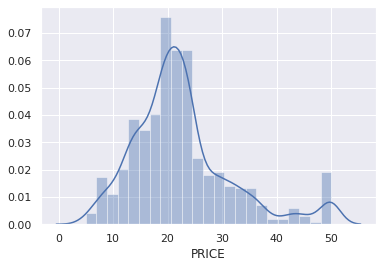

In [ ]:
#Let's us seaborn, because it is pretty. ;) 
#See more here. http://seaborn.pydata.org/tutorial/distributions.html
import seaborn as sns
sns.distplot(boston_df['PRICE']);

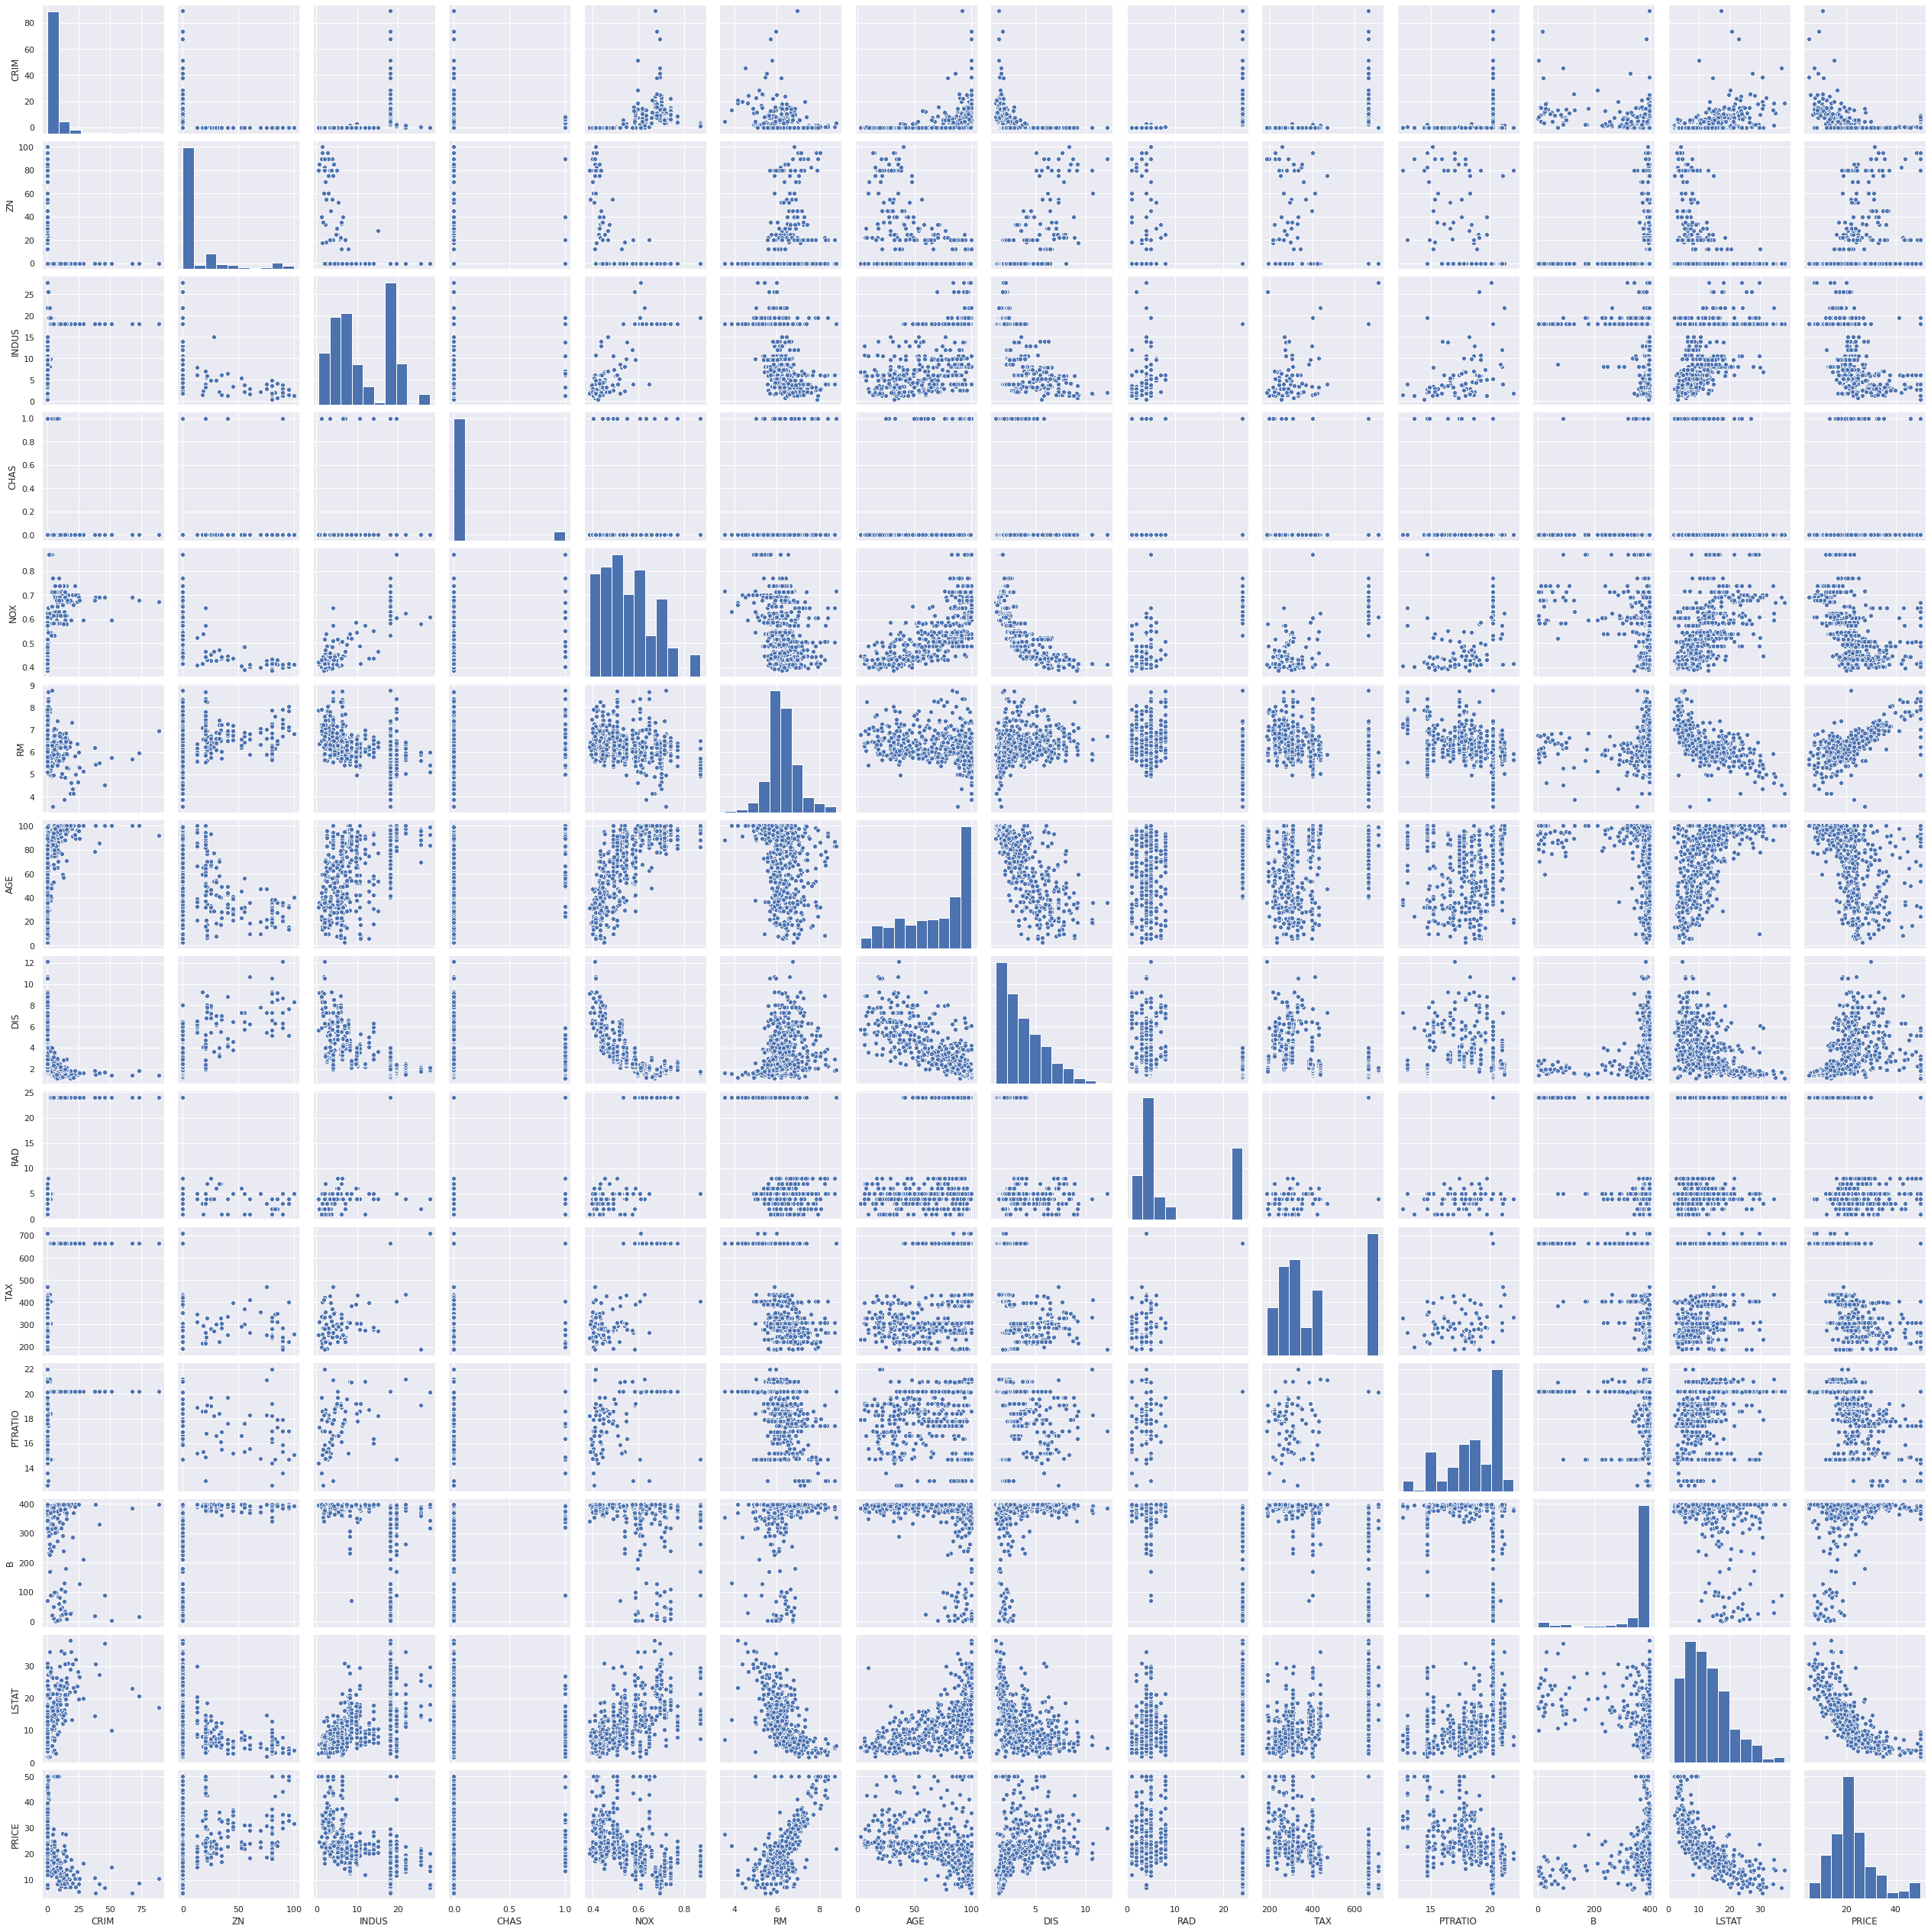

In [ ]:
#We can quickly look at other data. 
#Look at the bottom row to see thinks likely coorelated with price. 
#Look along the diagonal to see histograms of each. 
sns.pairplot(boston_df);

## Preparing to Model 
- It is common to separate `y` as the dependent variable and `X` as the matrix of independent variables.
- Here we are using `train_test_split` to split the test and train.
- This creates 4 subsets, with IV and DV separted: `X_train, X_test, y_train, y_test`
 


In [ ]:
#This will throw and error at import if haven't upgraded. 
# from sklearn.cross_validation  import train_test_split  
from sklearn.model_selection  import train_test_split
#y is the dependent variable.
y = boston_df['PRICE']
#As we know, iloc is used to slice the array by index number. Here this is the matrix of 
#independent variables.
X = boston_df.iloc[:,0:13]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(354, 13) (152, 13) (354,) (152,)


In [ ]:
#Define training hyperprameters.
batch_size = 50
num_epochs = 200
learning_rate = 0.01
size_hidden= 100

#Calculate some other hyperparameters based on data.  
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1



In [ ]:
#Create the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print("Executing the model on :",device)
class Net(torch.nn.Module):
    def __init__(self, n_feature, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer
        self.predict = torch.nn.Linear(size_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
net = Net(cols, size_hidden, n_output)

Executing the model on : cpu


In [ ]:
#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#Change to numpy arraay. 
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values

In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable
running_loss = 0.0
for epoch in range(num_epochs):
    #Shuffle just mixes up the dataset between epocs
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.FloatTensor(y_train[start:end]))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("outputs",outputs)
        #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
        loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    running_loss = 0.0



Epoch 1 loss:  269422.802734375
Epoch 2 loss:  74298.45971679688
Epoch 3 loss:  49142.05908203125
Epoch 4 loss:  40356.8701171875
Epoch 5 loss:  25088.677856445312
Epoch 6 loss:  22377.291748046875
Epoch 7 loss:  19981.943969726562
Epoch 8 loss:  18377.728393554688
Epoch 9 loss:  18916.928588867188
Epoch 10 loss:  17365.008422851562
Epoch 11 loss:  17527.261352539062
Epoch 12 loss:  16832.014282226562
Epoch 13 loss:  17486.990600585938
Epoch 14 loss:  17346.804565429688
Epoch 15 loss:  16722.7373046875
Epoch 16 loss:  15126.918579101562
Epoch 17 loss:  14799.306396484375
Epoch 18 loss:  14268.85498046875
Epoch 19 loss:  15002.420532226562
Epoch 20 loss:  15875.08203125
Epoch 21 loss:  15345.310546875
Epoch 22 loss:  13728.854553222656
Epoch 23 loss:  12727.48486328125
Epoch 24 loss:  14407.202880859375
Epoch 25 loss:  12649.470886230469
Epoch 26 loss:  12492.29736328125
Epoch 27 loss:  11559.286193847656
Epoch 28 loss:  12394.553955078125
Epoch 29 loss:  12267.896606445312
Epoch 30 los

In [ ]:

import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error

X = Variable(torch.FloatTensor(X_train)) 
result = net(X)
pred=result.data[:,0].numpy()
print(len(pred),len(y_train))
print(r2_score(pred,y_train))
print(mean_squared_error(pred,y_train))

354 354
0.8305214027792062
13.12357740390276


In [ ]:
import pandas as pd
from sklearn.metrics import r2_score
#This is a little bit tricky to get the resulting prediction.  
def calculate_performance(x,y=[]):
    """
    This function will return the r2 if passed x and y or return predictions if just passed x. 
    """
    # Evaluate the model with the test set. 
    X = Variable(torch.FloatTensor(x))  
    result = net(X) #This outputs the value for regression
    result=result.data[:,0].numpy()
  
    if len(y) != 0:
        r2=r2_score(result, y)
        print("R-Squared", r2)
        print("MSE",mean_squared_error(result,y))
        #print('Accuracy {:.2f}'.format(num_right / len(y)), "for a total of ", len(y), "records")
        return pd.DataFrame(data= {'actual': y, 'predicted': result})
    else:
        print("returning predictions")
        return result



In [ ]:
result1=calculate_performance(X_train,y_train)
result2=calculate_performance(X_test,y_test)


R-Squared 0.8305214027792062
MSE 13.12357740390276
R-Squared 0.636542430145748
MSE 24.026554016464903


## Modeling 
- First import the package: `from sklearn.linear_model import LinearRegression`
- Then create the model object.  
- Then fit the data. 
- This creates a trained model (an object) of class regression.
- The variety of methods and attributes available for regression are shown [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).


In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit( X_train, y_train )


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluating the Model Results
- You have fit a model. 
- You can now store this model, save the object to disk, or evaluate it with different outcomes. 
- Trained regression objects have coefficients (`coef_`) and intercepts (`intercept_`) as attributes. 
- R-Squared is determined from the `score` method of the regression object.
- For Regression, we are going to use the coefficient of determination as our way of evaluating the results, [also referred to as R-Squared](https://en.wikipedia.org/wiki/Coefficient_of_determination)

In [ ]:

print('R2 for Train)', lm.score( X_train, y_train ))
print('R2 for Test (cross validation)', lm.score(X_test, y_test))

R2 for Train) 0.7645451026942549
R2 for Test (cross validation) 0.6733825506400191



Copyright [AnalyticsDojo](http://rpi.analyticsdojo.com) 2016.
This work is licensed under the [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/) license agreement.


# Red wine quality data set

https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

## Prepare Data

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
df = pd.read_csv("https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv",delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [32]:
df.shape

(1599, 12)

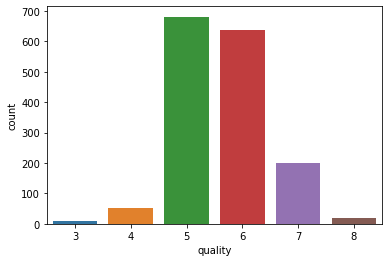

In [33]:
sns.countplot(x = 'quality', data=df)

In [34]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print(X.shape,y.shape)

(1599, 11) (1599,)


## Train — Validation — Test

To create the train-val-test split, we’ll use train_test_split() from Sklearn.
First, we’ll split our data into train+val and test sets. Then, we'll further split our train+val set to create our train and val sets.
Because there’s a “class” imbalance, we want to have equal distribution of all output classes in our train, validation, and test sets.
To do that, we use the stratify option in function train_test_split().
Remember that stratification only works with classes, not numbers. So, in general, we can bin our numbers into classes using quartiles, deciles, histogram(np.histogram()) and so on. So, you would have to create a new dataframe which contains the output and it's "class". This "class" was obtained using the above mentioned methods.
In our case, let’s use the numbers as is because they are already like classes. After we split our data, we can convert the output to float (because regression).


In [35]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)
print(X_train.shape,y_train.shape)

(1151, 11) (1151,)


## Normalize Input

Neural networks need data that lies between the range of (0,1). There’s a ton of material available online on why we need to do it.
To scale our values, we’ll use the MinMaxScaler() from Sklearn. The MinMaxScaler transforms features by scaling each feature to a given range which is (0,1) in our case.

Notice that we use .fit_transform() on X_train while we use .transform() on X_val and X_test.

We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage. fit_transform() calculates scaling values and applies them while .transform() only applies the calculated values.

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_train.shape, y_train.shape)

(1151, 11) (1151,)


Visualize Class Distribution in Train, Val, and Test

Once we’ve split our data into train, validation, and test sets, let’s make sure the distribution of classes is equal in all three sets.
To do that, let’s create a function called get_class_distribution(). This function takes as input the obj y , ie. y_train, y_val, or y_test. Inside the function, we initialize a dictionary which contains the output classes as keys and their count as values. The counts are all initialized to 0.
We then loop through our y object and update our dictionary.

In [37]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

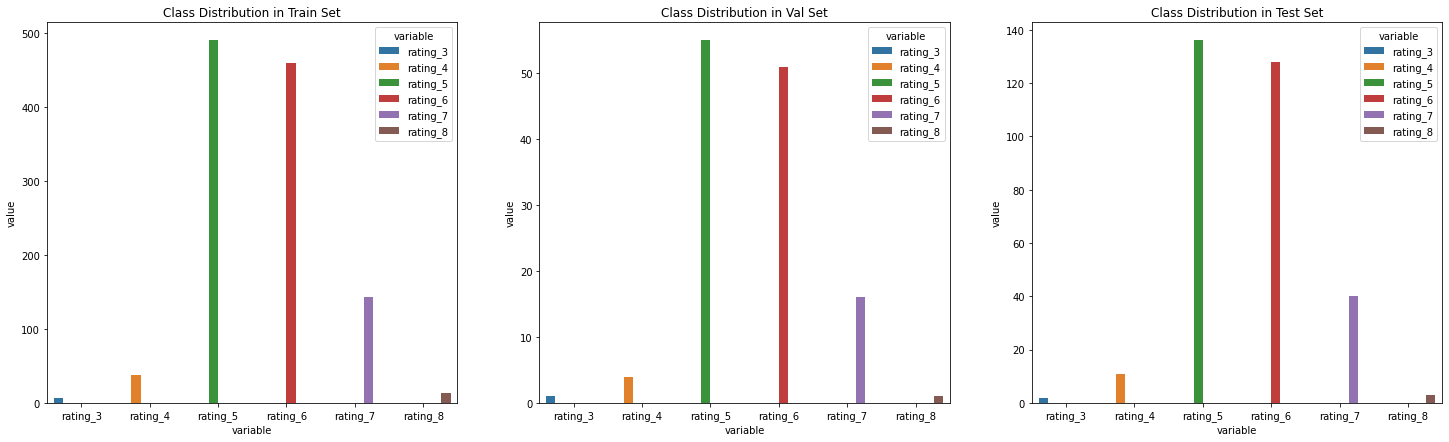

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Val
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Convert Output Variable to Float

In [39]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

## Neural Network

Initialize Dataset

In [40]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [66]:
print(X_train.shape,torch.from_numpy(X_train).float().shape )

(1151, 11) torch.Size([1151, 11])


In [65]:
X_train

array([[-1.73441578e-02, -1.12533328e+00,  7.57301120e-01, ...,
         4.55029703e-01,  6.42797341e-01,  2.09815859e+00],
       [ 1.49589568e+00,  6.84806828e-04,  1.11239482e+00, ...,
        -1.55536094e+00, -5.63027613e-01,  1.16576967e+00],
       [ 3.90066569e-01,  2.82189328e-01, -1.05069305e-01, ...,
        -5.17739963e-01, -5.05607377e-01, -6.99008165e-01],
       ...,
       [-7.15762547e-01, -1.46313870e+00,  1.67039922e+00, ...,
         4.55029703e-01,  3.55696162e-01,  1.40141862e-01],
       [-5.41157949e-01,  2.82189328e-01, -1.37326111e+00, ...,
         9.08988880e-01, -4.48187141e-01,  7.92814105e-01],
       [ 7.39275763e-01,  1.97121645e+00,  4.71137111e-02, ...,
        -4.52888652e-01, -7.35288321e-01, -9.78724841e-01]])

In [64]:
torch.from_numpy(X_train).float()

tensor([[-1.7344e-02, -1.1253e+00,  7.5730e-01,  ...,  4.5503e-01,
          6.4280e-01,  2.0982e+00],
        [ 1.4959e+00,  6.8481e-04,  1.1124e+00,  ..., -1.5554e+00,
         -5.6303e-01,  1.1658e+00],
        [ 3.9007e-01,  2.8219e-01, -1.0507e-01,  ..., -5.1774e-01,
         -5.0561e-01, -6.9901e-01],
        ...,
        [-7.1576e-01, -1.4631e+00,  1.6704e+00,  ...,  4.5503e-01,
          3.5570e-01,  1.4014e-01],
        [-5.4116e-01,  2.8219e-01, -1.3733e+00,  ...,  9.0899e-01,
         -4.4819e-01,  7.9281e-01],
        [ 7.3928e-01,  1.9712e+00,  4.7114e-02,  ..., -4.5289e-01,
         -7.3529e-01, -9.7872e-01]])

Model Params

In [41]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

Initialize Dataloader

DataLoader supports automatically collating individual fetched data samples into batches via arguments batch_size, drop_last, and batch_sampler.

DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [42]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Define Neural Network Architecture

We have a simple 3 layer feedforward neural net here. We use ReLU as the activation at all layers.

In [43]:
class MultipleRegression(nn.Module):
  def __init__(self, num_features):
      super(MultipleRegression, self).__init__()
      
      self.layer_1 = nn.Linear(num_features, 16)
      self.layer_2 = nn.Linear(16, 32)
      self.layer_3 = nn.Linear(32, 16)
      self.layer_out = nn.Linear(16, 1)
      
      self.relu = nn.ReLU()
  def forward(self, inputs):
      x = self.relu(self.layer_1(inputs))
      x = self.relu(self.layer_2(x))
      x = self.relu(self.layer_3(x))
      x = self.layer_out(x)
      return (x)
  def predict(self, test_inputs):
      x = self.relu(self.layer_1(test_inputs))
      x = self.relu(self.layer_2(x))
      x = self.relu(self.layer_3(x))
      x = self.layer_out(x)
      return (x)


In [44]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [56]:
NUM_FEATURES

11

Initialize the model, optimizer, and loss function. Transfer the model to GPU.

In [45]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)

MultipleRegression(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train model

Before we start our training, let’s define a dictionary which will store the loss/epoch for both train and validation sets.

In [47]:
loss_stats = {
    'train': [],
    "val": []
}

In [57]:
EPOCHS

150

In [48]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
  # TRAINING
  train_epoch_loss = 0 # After every epoch, we’ll print out the loss and reset it back to 0.
  model.train() # model.train() tells PyTorch that you’re in training mode.
  for X_train_batch, y_train_batch in train_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
       #Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.
      optimizer.zero_grad()
      
      y_train_pred = model(X_train_batch)
      # we then obtain a prediction
      train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
      # get the loss(and accuracy) for that mini-batch
      train_loss.backward()
      # perform back-propagation using optimizer.step()
      optimizer.step()
      # Finally, we add all the mini-batch losses to obtain the average loss for that epoch
      train_epoch_loss += train_loss.item()
      
      
  # VALIDATION 
  #tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.   
  with torch.no_grad():
      
      val_epoch_loss = 0
      
      model.eval() # we’ll call model.eval() when we test our model
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
          
          val_epoch_loss += val_loss.item()
  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
  
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 001: | Train Loss: 31.09890 | Val Loss: 30.20150
Epoch 002: | Train Loss: 29.42544 | Val Loss: 27.98206
Epoch 003: | Train Loss: 26.20445 | Val Loss: 23.58174
Epoch 004: | Train Loss: 20.11776 | Val Loss: 15.68943
Epoch 005: | Train Loss: 11.10996 | Val Loss: 6.95010
Epoch 006: | Train Loss: 5.15403 | Val Loss: 4.34876
Epoch 007: | Train Loss: 3.74525 | Val Loss: 3.29138
Epoch 008: | Train Loss: 2.84378 | Val Loss: 2.54865
Epoch 009: | Train Loss: 2.26049 | Val Loss: 1.98429
Epoch 010: | Train Loss: 1.85691 | Val Loss: 1.64528
Epoch 011: | Train Loss: 1.59331 | Val Loss: 1.38409
Epoch 012: | Train Loss: 1.39788 | Val Loss: 1.22240
Epoch 013: | Train Loss: 1.24993 | Val Loss: 1.09896
Epoch 014: | Train Loss: 1.14182 | Val Loss: 1.00000
Epoch 015: | Train Loss: 1.05081 | Val Loss: 0.93049
Epoch 016: | Train Loss: 0.97067 | Val Loss: 0.85207
Epoch 017: | Train Loss: 0.89993 | Val Loss: 0.79477
Epoch 018: | Train Loss: 0.84162 | Val Loss: 0.73922
Epoch 019: | Train Loss: 0.78869 | Va

In [67]:
for X_train_batch, y_train_batch in train_loader:
  print(X_train_batch.shape, y_train_batch.shape)

torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([63, 11]) torch.Size([63])


In [69]:
 X_train_batch.to(device).shape

torch.Size([63, 11])

## Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

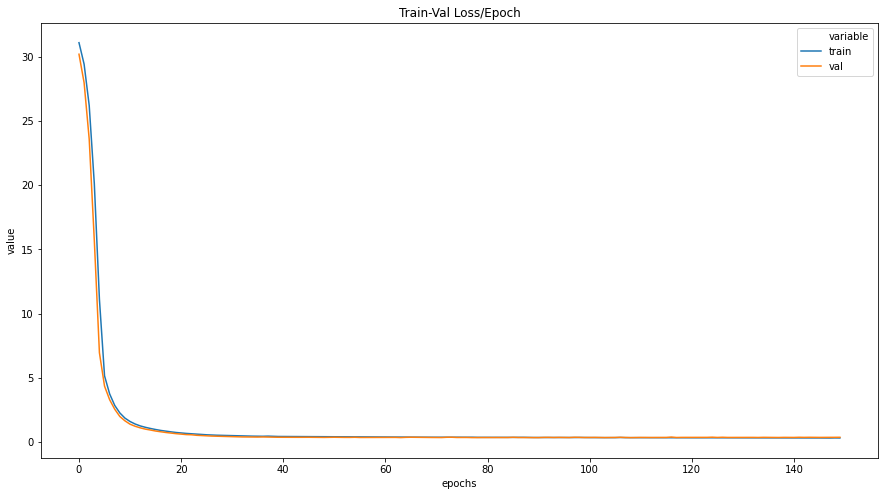

In [49]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

## Test Model

In [50]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [51]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.42090399697799086
R^2 : 0.3477121906509738
